In [7]:
import pandas as pd
import numpy as np
import foxes
import foxes.variables as FV
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error
import customFunctions as fct
import matplotlib.pyplot as plt
import sklearn.neighbors
import os
import foxes.input.farm_layout as layout

# Task 1

In [2]:
data_ERA5 = fct.read_ts_csv(f'reanalysis.csv')
data_LIDAR = fct.read_ts_csv(f'measurements/lidar.csv')

# Resample the data to 1h intervals
data_ERA5 = data_ERA5.resample('h', on='Time').mean()
data_ERA5['u100'], data_ERA5['v100'] = fct.wind_components(data_ERA5.iloc[:, 0], data_ERA5.iloc[:, 1])

data_LIDAR = data_LIDAR.resample('h', on='Time').mean()
data_LIDAR['u99.2'], data_LIDAR['v99.2'] = fct.wind_components(data_LIDAR.iloc[:, 0], data_LIDAR.iloc[:, 1])

# create a merged dataframe containing the ERA5 and the LIDAR data
wind_data = pd.merge(data_LIDAR, data_ERA5, how='right', on='Time')

# Ensure that the datetime format is used for the datetime index
wind_data.index = pd.to_datetime(wind_data.index)

wind_data['Mon']      = wind_data.index.strftime('%m')
wind_data['Hour']     = wind_data.index.strftime('%H')

# Task 2

# Task 3

The long-term correction of the ERA05 model data using the LIDAR measurements.

In [3]:
param_grid = {
              "n_neighbors"       : [2,5,12,30],
              "leaf_size"         : [1, 2, 3,15,30],
              "p"                 : [1,2],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

classifier = sklearn.neighbors.KNeighborsRegressor()

u_predictions, meas_idx = fct.correct_long_term_wind(wind_data[['u100','WS100','WD100','Mon','Hour']], wind_data['u99.2'], 
                                                   classifier=classifier, param_grid=param_grid)
v_predictions, _ = fct.correct_long_term_wind(wind_data[['v100','WS100','WD100','Mon','Hour']], wind_data['v99.2'], 
                                                   classifier=classifier, param_grid=param_grid)

wind_data['WS100_corr'], wind_data['WD100_corr'] = fct.wind_speed_dir(u_predictions, v_predictions)
wind_data

Best score:
-2.97
Best parameters:
{'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
Validation scores - Without Correction:
-------------------------
R2-Score:  0.9492
MSE:  2.9754
RMSE:  1.7249
MAE:  1.1458
MAPE:  101.9833
Validation scores - Model and Test Data:
-------------------------
R2-Score:  0.9496
MSE:  2.9301
RMSE:  1.7117
MAE:  1.1201
MAPE:  88.2637
Best score:
-4.28
Best parameters:
{'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
Validation scores - Without Correction:
-------------------------
R2-Score:  0.8909
MSE:  4.7524
RMSE:  2.18
MAE:  1.2255
MAPE:  99.5566
Validation scores - Model and Test Data:
-------------------------
R2-Score:  0.9115
MSE:  3.8683
RMSE:  1.9668
MAE:  1.1948
MAPE:  139.7995


,WS-99.2,WD-99.2,u99.2,v99.2,WS100,WD100,u100,v100,Mon,Hour,WS100_corr,WD100_corr
Time,,,,,,,,,,,,
1995-01-01 00:00:00,NaN,NaN,NaN,NaN,15.217,313.6,11.019723,-10.493941,01,00,14.292690,312.493638
1995-01-01 01:00:00,NaN,NaN,NaN,NaN,16.807,311.4,12.607117,-11.114669,01,01,15.948254,309.166200
1995-01-01 02:00:00,NaN,NaN,NaN,NaN,17.562,313.0,12.844034,-11.977255,01,02,16.515640,308.807058
1995-01-01 03:00:00,NaN,NaN,NaN,NaN,19.496,310.7,14.780587,-12.713310,01,03,18.037083,309.441942
1995-01-01 04:00:00,NaN,NaN,NaN,NaN,21.631,312.3,15.998960,-14.557934,01,04,19.274478,310.432410
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,NaN,NaN,NaN,NaN,21.859,225.5,15.590942,15.321176,12,19,21.295456,230.472643
2024-12-31 20:00:00,NaN,NaN,NaN,NaN,21.991,226.8,16.030749,15.053875,12,20,21.068217,232.927576
2024-12-31 21:00:00,NaN,NaN,NaN,NaN,22.290,228.4,16.668419,14.798915,12,21,21.175816,232.616918


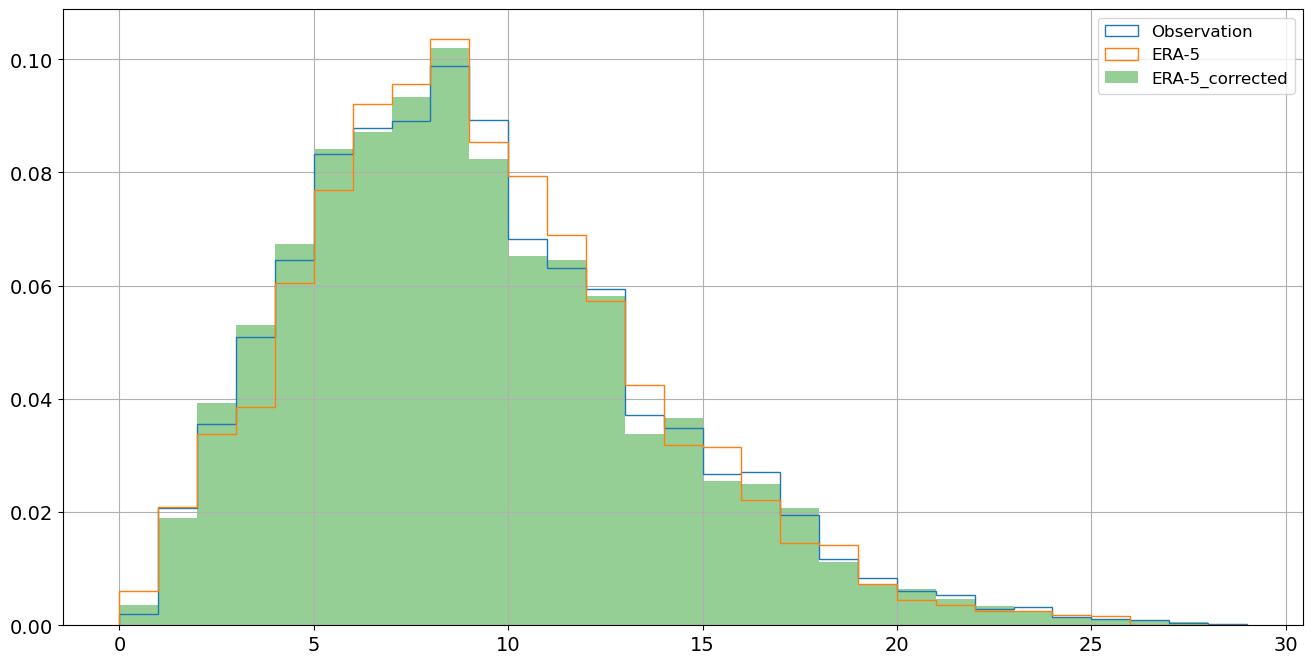

In [4]:
nbins = np.arange(0, 30, 1)

fig = plt.figure(figsize=(16,8))
plt.hist(wind_data['WS-99.2'].iloc[meas_idx], nbins, label='Observation', histtype='step', density=True)
plt.hist(wind_data['WS100'].iloc[meas_idx], nbins, label='ERA-5', histtype='step', density=True)
plt.hist(wind_data['WS100_corr'].iloc[meas_idx], nbins, label='ERA-5_corrected', alpha=0.5, density=True)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)
plt.grid()

In [5]:
print('Wind speed R2-score')
print('Corrected:')
print(wind_data['WS-99.2'].iloc[meas_idx].corr(wind_data['WS100_corr'].iloc[meas_idx])**2)
print('Not Corrected:')
print(wind_data['WS-99.2'].iloc[meas_idx].corr(wind_data['WS100'].iloc[meas_idx])**2)

print('Wind direction R2-score')
print('Corrected:')
print(wind_data['WD-99.2'].iloc[meas_idx].corr(wind_data['WD100_corr'].iloc[meas_idx])**2)
print('Not Corrected:')
print(wind_data['WD-99.2'].iloc[meas_idx].corr(wind_data['WD100'].iloc[meas_idx])**2)

Wind speed R2-score
Corrected:
0.9713691433014832
Not Corrected:
0.9237537762511515
Wind direction R2-score
Corrected:
0.9300256509907887
Not Corrected:
0.7864686069813114


# Task 4

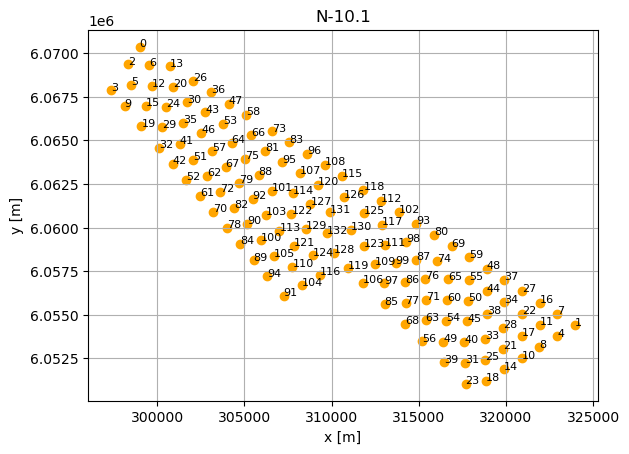

In [8]:
farm = foxes.WindFarm(name="N-10.1")
layout_df = pd.read_csv(
    "turbine-info/coordinates/area_of_interest/layout-N-10.1.geom.csv",
    index_col=None
)
layout.add_from_csv(farm, layout_df, turbine_models=["NREL5MW"], verbosity=0)
# Corrected section
layout_fig = foxes.output.FarmLayoutOutput(farm).get_figure()
fig = layout_fig.figure  # Get the Figure from the Axes object
fig.tight_layout()
plt.show()

In [ ]:
os.environ["FOXES_ENGINE"]  = "threads"
os.environ["FOXES_N_PROCS"] = "1"

era5_corrected = wind_data.copy()
era5_corrected["WS"] = wind_data["WS100_corr"]
era5_corrected["WD"] = wind_data["WD100_corr"]
era5_corrected["TI"] = 0.10  # constant turbulence
era5_corrected["Time"] = era5_corrected.index
era5_corrected = era5_corrected.dropna(subset=["WS", "WD"])

# Run FOXES base case algorithm
algo_base = fct.setup_algo(
    wind_data=era5_corrected,
    windfarm_name="N-10.1",
    wake_models=["Bastankhah2014_quadratic_ka02"]
)

# Calculate yield and performance
stats_base, summ_base = fct.compute_yield(algo_base)

# Print summary results
print(f"Farm ambient power [MW]: {summ_base['farm_ambient_power_MW']:.1f}")
print(f"Farm net power     [MW]: {summ_base['farm_net_power_MW']:.1f}")
print(f"Farm efficiency        : {summ_base['farm_efficiency']:.3f}")
print(f"Annual yield      [GWh]: {summ_base['annual_yield_GWh']:.2f}")

# Farm net power time series
results_base = algo_base.calc_farm(calc_parameters={"chunk_size_states": 250})
ts_power = results_base["P"].sum(dim="turbine") / 1000  # MW

plt.figure(figsize=(10, 4))
ts_power.plot()
plt.title("Hourly Farm Net Power (Corrected ERA5, Base Wake Model)")
plt.ylabel("Power [MW]")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Load layout and plot turbine yield spatially
layout_df = pd.read_csv("turbine-info/coordinates/area_of_interest/layout-N-10.1.geom.csv")
pos = layout_df[["x", "y"]].values
yields_base = stats_base["Net Yield     [GWh]"].values

plt.figure(figsize=(6, 6))
sc = plt.scatter(pos[:, 0], pos[:, 1], c=yields_base, cmap="viridis", s=50)
plt.colorbar(sc, label="Annual Net Yield [GWh]")
plt.title("Turbine Net Yield (Corrected ERA5, Base Wake Model)")
plt.axis("equal")
plt.tight_layout()
plt.show()